This is the simple mock galaxy catalog made of randomly shaped and placed galaxies for testing purposes

In [1]:
import ngmix
from ngmix.medsreaders import NGMixMEDS
import numpy as np
import os
import time
from astropy.table import Table, vstack, hstack

import pickle
import numpy as np
import pandas as pd

import sklearn.neighbors as neighbors

from importlib import reload
import copy
import synthetic.render.generator as gen

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

import multiprocessing as mp

import sys
import os
import math
import logging
import time
import galsim
import fitsio as fio

import ngmix

import synthetic.render.render as render
import synthetic.render.icl as icl
import synthetic.render.frame as frame
import synthetic.mcal as mcal

# import images
import meds
import subprocess
import psfex

In [2]:
def toflux(mag):
    flux = 10**((mag - 30)/-2.5)
    return flux

In [3]:
20 * 20

400

In [4]:
np.sqrt(40000)

200.0

In [5]:
np.random.seed(5000)
nobjects = 40000
canvas_size = 10000
padding = 40
mock_catalog = pd.DataFrame()


x = np.linspace(padding, canvas_size - padding, 200)
y = np.linspace(padding, canvas_size - padding, 200)
xx, yy = np.meshgrid(x, y)
xx = xx.flatten()
yy = yy.flatten()


# this is something of an artifact, the X, Y is starting at 0, not at the image center... might need to be fixed
mock_catalog["X"] = xx
mock_catalog["Y"] = yy
lsizes = np.random.normal(loc=0.4, scale=0.2, size=nobjects)
mock_catalog["TSIZE"] = 10 # 10**(lsizes - 1) * 2
mock_catalog["FRACDEV"] = 1 #np.random.uniform(0, 1, size=nobjects)
mock_catalog["MAG_I"] = 21 #np.random.normal(loc=22, scale=0.5, size=nobjects)
mock_catalog["FLUX_I"] = toflux(mock_catalog["MAG_I"])
mock_catalog["G1"] = np.random.normal(loc=0, scale=0.25, size=nobjects) + 0.02
mock_catalog["G2"] = np.random.normal(loc=0, scale=0.25, size=nobjects) - 0.02
g1 = mock_catalog["G1"]
g2 = mock_catalog["G2"]
amp = np.sqrt(g1**2 + g2**2) 
ii = amp > 0.8
mock_catalog['G1'][ii] *= 0.8 / amp[ii]
mock_catalog['G2'][ii] *= 0.8 / amp[ii]
g1 = mock_catalog["G1"]
g2 = mock_catalog["G2"]
amp = np.sqrt(g1**2 + g2**2) 
# mock_catalog[""]
# ii


# ra = (mock_catalog['X'] - canvas_size) * 0.264 / 60 # arcmin
# dec = (mock_catalog['Y'] - canvas_size) * 0.264 / 60 # arcmin
# dists = np.sqrt(ra**2 + dec**2)
# shears = np.sqrt(1 / dists  / 2) # just for illustration purposes
# shears[shears > 0.8] = 0.8

# phis =  np.arctan2(dec, ra)
# es1 = (-1. * shears * np.cos(2 * phis))
# es2 = (-1. * shears * np.sin(2 * phis))
# mock_catalog["G1"] = es1
# mock_catalog["G2"] = es2

/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [6]:
mock_catalog["TSIZE"].shape

(40000,)

In [7]:
name = 'test_canvas_grid'
print(name)
fr = frame.Frame(mock_catalog, name=name, noise_std=1, canvas_size=canvas_size)
fr.render()
fr.extract()

test_canvas_grid
starting postage stamp calculations in 100 processes
sex test_canvas_grid.fits -c config.sex -CATALOG_NAME test_canvas_grid_cat.fits -CHECKIMAGE_NAME test_canvas_grid_seg.fits


In [8]:
fr.scat

array([(6.92320790e-03, -0.2755529 , 4875.9766,   40.544773,     1, 21.387135, 0.00865148, 21.292967, 0.01022987, 22.87727 , 0.00798005, 21.26309 , 0.01156185, 21.26309 , 0.01156185, 3124.3801, 33.263004, 3124.3801, 33.263004, 2787.0608, 22.202765, 4.280265 , 0.38655406, 1.7552826, 45.347836, 313, 33.40312106,  6.01763854,  1.65161232,   35,   47, 4854, 4911, 5.788123 , 2.432774 ,   3.4388824, 26.497152, 22.966629, 1.6832445e-06, 6.91796940e-03, -0.27555094, 0.00032156, 0.00013515,  -3.4387858,  0, 7.9049454, 0.0005797 , 2.3792276, 0.02841712, 4.6944857, 706.4678 , 0.5796955 , [[-1.14466250e-02, -1.24161863e+00,  2.81945556e-01,  9.55445647e-01,  1.27845645e+00, -7.79157877e-01, -7.32151628e-01, -1.26708531e+00,  4.01593447e-01, -1.66962647e+00, -1.00454485e+00, -7.24458098e-01, -3.12075466e-01, -1.14258885e+00, -7.62453794e-01, -8.70795727e-01, -9.81861711e-01, -9.01038468e-01,  4.10086721e-01, -1.56676963e-01, -5.56798935e-01, -2.15857983e+00,  2.55502760e-01,  8.33983362e-01, -1.058

In [9]:
# noise = np.random.normal(scale=fr.noise_std, size=(fr.canvas_size, fr.canvas_size))
noise = np.ones(shape=(fr.canvas_size, fr.canvas_size))
wcanvas = galsim.ImageF(noise, wcs=fr.canvas.wcs)
wcanvas.write(name + '_weight.fits', clobber=True)
# noise.array = noise
# wcanvas.setValue(noise)

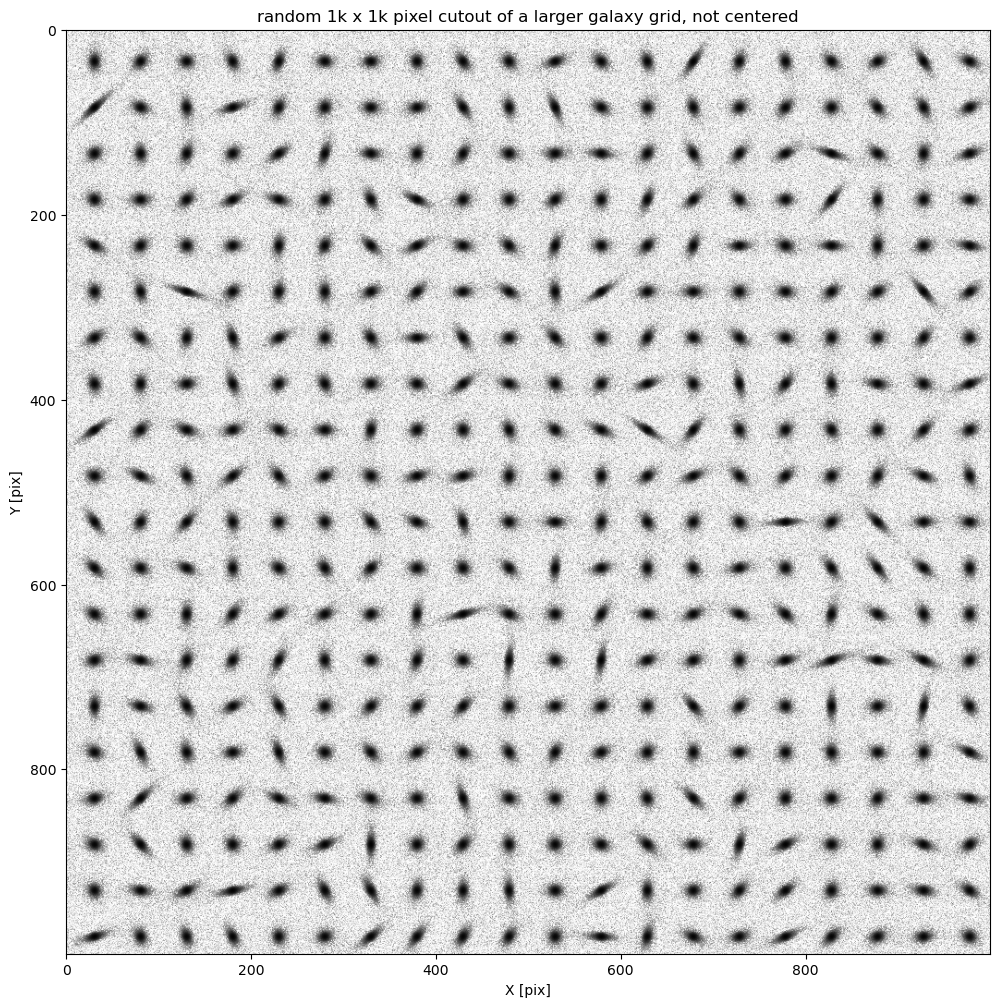

In [10]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)

arr = fr.canvas.array[2000:3000, 3000:4000]
ax.imshow(np.arcsinh(arr) / arr, cmap=plt.cm.gray)
ax.set_xlabel("X [pix]")
ax.set_ylabel("Y [pix]")
ax.set_title('random 1k x 1k pixel cutout of a larger galaxy grid, not centered')
fig.savefig("grid_illustration.png", bbox_inches="tight")

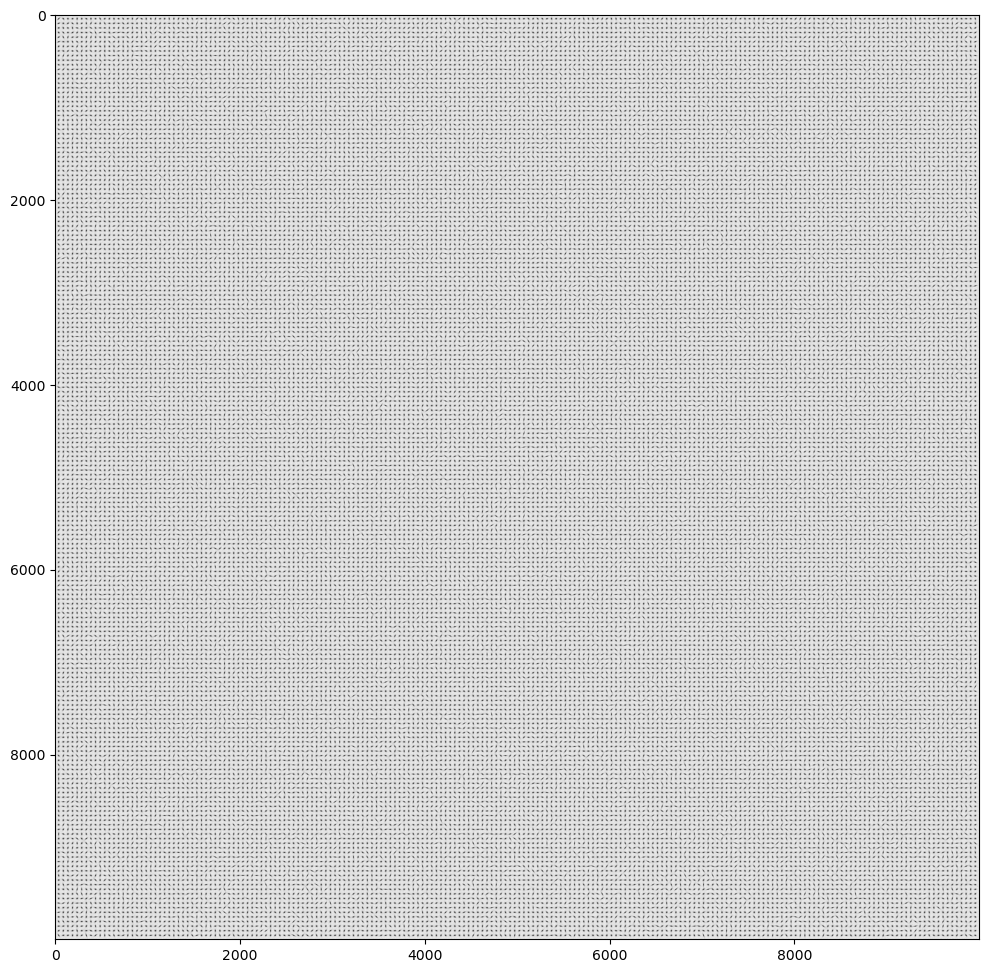

In [11]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)

arr = fr.canvas.array
ax.imshow(np.arcsinh(arr) / arr, cmap=plt.cm.gray)

# MEDS creation

In [12]:
nimage = 1
nobj = len(fr.scat)
obj_data = meds.util.get_meds_input_struct(nobj, extra_fields=[("X_IMAGE", "f8"), ("Y_IMAGE", "f8")])
obj_data['id'] = fr.scat['NUMBER']
obj_data['box_size'] = np.ones(nobj) * 32
obj_data['ra'] = fr.scat['ALPHAWIN_J2000'] + 0.264 / 3600
obj_data['dec'] = fr.scat['DELTAWIN_J2000'] - 0.264 / 3600
obj_data['X_IMAGE'] = fr.scat['X_IMAGE']
obj_data['Y_IMAGE'] = fr.scat['Y_IMAGE']

In [13]:
image_info= meds.util.get_image_info_struct(nimage, 30)

image_info['image_path'][0] = './test_canvas_grid.fits'
image_info['weight_path'][0] = './test_canvas_grid_weight.fits' 
image_info['seg_path'][0] = './test_canvas_grid_seg.fits'
image_info['magzp'] = 30.

config = {'first_image_is_coadd': False,'cutout_types':['weight', 'seg'],'psf_type':'psfex'}

In [14]:
len('./test_canvas_grid_weight.fits' )

30

In [15]:
mpex = frame.MockPSF(fr.df.image_epsf.array)

In [16]:
import psfex

# row=514.25
# col=610.00
pex = psfex.PSFEx("../meds/star_canvas_cat.psf")
# image = pex.get_rec(row, col)
psf_data = [pex,]
# psf_data = [mpex]

In [17]:
mm = meds.MEDSMaker(obj_data=obj_data, image_info=image_info, config=config, psf_data=psf_data)

writing cutouts for: ['image', 'weight', 'seg']


In [18]:
mpex.get_rec(0, 0).shape

(24, 24)

In [19]:
pex.get_rec(0, 0).shape

(23, 23)

In [20]:
pex.get_center(0, 0)

array([11., 11.])

In [21]:
mm.write("testmeds_grid.fits")

file    1 of    1: 'b'./test_canvas_grid.fits''
    first cut:   40000 of  40000 objects
    second cut:  40000 of  40000 objects
40000/40000 had ncut > 0


/home/moon/vargatn/anaconda3/envs/galsim/lib/python3.7/site-packages/meds/util.py:380: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  phat = numpy.array([-1.0*sinp,cosp,0.0]).T


setting start rows and pixel count
total pixels: 40960000
setting psf layout for PSFEx
meds layout build time: 1.007979 seconds
opening output MEDS file: 'testmeds_grid.fits'
writing object_data
writing image_info
writing metadata
    reserving image mosaic
    reserving weight mosaic
    reserving seg mosaic
    reserving psf mosaic
writing image cutouts
    1/1 image b'./test_canvas_grid.fits'
    no background for image
writing weight cutouts
    1/1 weight b'./test_canvas_grid_weight.fits'
writing seg cutouts
    1/1 seg b'./test_canvas_grid_seg.fits'
writing psf cutouts
output is in: testmeds_grid.fits


In [22]:
! ls

config.sex		metacal_grid_033.fits  metacal_grid_074.fits
default.conv		metacal_grid_034.fits  metacal_grid_075.fits
default.nnw		metacal_grid_035.fits  metacal_grid_076.fits
default.param		metacal_grid_036.fits  metacal_grid_077.fits
default.sex		metacal_grid_037.fits  metacal_grid_078.fits
ESRA_Pipeline_01.ipynb	metacal_grid_038.fits  metacal_grid_079.fits
ESRA_Pipeline_02.ipynb	metacal_grid_039.fits  metacal_grid_080.fits
grid_illustration.png	metacal_grid_040.fits  metacal_grid_081.fits
metacal_grid_000.fits	metacal_grid_041.fits  metacal_grid_082.fits
metacal_grid_001.fits	metacal_grid_042.fits  metacal_grid_083.fits
metacal_grid_002.fits	metacal_grid_043.fits  metacal_grid_084.fits
metacal_grid_003.fits	metacal_grid_044.fits  metacal_grid_085.fits
metacal_grid_004.fits	metacal_grid_045.fits  metacal_grid_086.fits
metacal_grid_005.fits	metacal_grid_046.fits  metacal_grid_087.fits
metacal_grid_006.fits	metacal_grid_047.fits  metacal_grid_088.fits
metacal_grid_007.fits	metacal_grid_0

In [23]:
m = meds.MEDS('testmeds_grid.fits')

In [24]:
cat = m.get_cat()

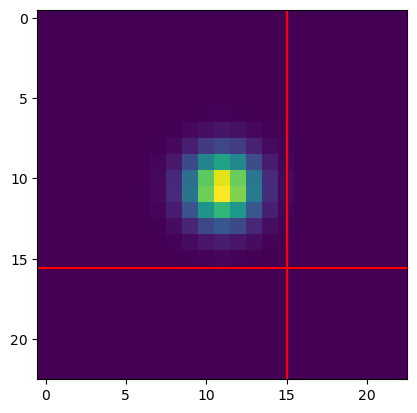

In [25]:
icut = 962
im = m.get_cutout(icut, 0, 'psf')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(im)
ax.axhline(cat['cutout_row'][icut][0], color="red")
ax.axvline(cat['cutout_col'][icut][0], color="red")


# METACAL

In [29]:
reload(mcal)

<module 'synthetic.mcal' from '/home/moon/vargatn/DES/SYNTHETIC/synthetic/synthetic/mcal.py'>

In [30]:
def infomaker(maxnum, medsfile, outfile_root, nchunk=100):
    lst = mcal.partition(np.arange(maxnum), n=nchunk)
    
    infodicts = []
    for i, tmp in enumerate(lst):
        info = {
            "medsfile": medsfile,
            "outfile": outfile_root + "_{:03d}.fits".format(i),
            "outdir": None,
            "start": tmp.min(),
            "end": tmp.max() + 1, # due to how lists work, we need to include the one higher value here
        }
        infodicts.append(info)
    return infodicts

In [32]:
infodicts = infomaker(len(fr.scat), 'testmeds_grid.fits', "metacal_grid")

In [33]:
mcal.multi_mcal(infodicts, nprocess=140)

starting metacal calculations in 100 processes
     Number of calls to function has reached maxfev = 2000.
Total fitting and stacking time: 301.22559356689453 seconds
Total fitting and stacking time: 303.3551490306854 seconds
Total fitting and stacking time: 303.6259446144104 seconds
Total fitting and stacking time: 309.1054787635803 seconds
Total fitting and stacking time: 311.23398184776306 seconds
Total fitting and stacking time: 312.93474531173706 seconds
Total fitting and stacking time: 320.71805810928345 seconds
Total fitting and stacking time: 325.2815749645233 seconds
Total fitting and stacking time: 327.1372845172882 seconds
Total fitting and stacking time: 329.80950140953064 seconds
Total fitting and stacking time: 330.32202076911926 seconds
Total fitting and stacking time: 330.6608271598816 seconds
Total fitting and stacking time: 333.9575378894806 seconds
Total fitting and stacking time: 334.1027178764343 seconds
Total fitting and stacking time: 335.43564677238464 seconds
T

In [34]:
def collater(infodicts, dtype=None):
#     fnames = []
    tab = []
    names = []
    for i, info in enumerate(infodicts):

            
        fname = info['outfile']
        tmp = fio.read(fname)

        if i == 0:
            for i, name in enumerate(tmp.dtype.names):
                if 'err' not in name:            
                    names.append(name)

        tab.append(tmp[names])
        
        
    return np.hstack(tab)
        


In [35]:
tab = collater(infodicts)

In [36]:
tab["g_noshear"][:, ]

array([[ 0.34422807,  0.03719962],
       [ 0.35407502, -0.10870402],
       [ 0.4068107 , -0.2211819 ],
       ...,
       [ 0.04744377, -0.03891048],
       [-0.33251552,  0.16171099],
       [ 0.33036883,  0.14597544]])

In [45]:
gest1_raw =tab["g_noshear"][:, 0].mean()
gest2_raw =tab["g_noshear"][:, 1].mean()

gest1 =tab["g_noshear"][:, 0].mean() / tab['r11'].mean()
gest2 =tab["g_noshear"][:, 1].mean() / tab['r22'].mean()


In [44]:
print("the measured shape  <e> with 40k galaxies")
print("g1 = {:.4f}".format(gest1_raw), "the input shape is 0.02")
print("g2 = {:.4f}".format(gest2_raw), "the input shape is -0.02")
print('')
print('METACALIBRATION:')
print("the measured shape  <e> / <R> with 40k galaxies")
print("g1 = {:.4f}".format(gest1), "the input shape is 0.02")
print("g2 = {:.4f}".format(gest2), "the input shape is -0.02")

the measured shape  <e> with 40k galaxies
g1 = 0.0141 the input shape is 0.02
g2 = -0.0128 the input shape is -0.02

METACALIBRATION:
the measured shape  <e> / <R> with 40k galaxies
g1 = 0.0157 the input shape is 0.02
g2 = -0.0143 the input shape is -0.02


In [46]:
tab['r11'].mean()

0.8967744384795098

In [383]:
gest1

0.032299763007321534

In [384]:
gest1_raw

0.025555512136885825

In [378]:
taba['g2_MC'] / tab['r22']


array([-0.01470183,  0.3652118 , -0.22067616, ...,  0.33983599,
        0.23799881, -0.21859896])

In [99]:
tab['g1_MC'].mean()

0.2911885225777538

In [100]:
tab['g2_MC'].mean()

-0.21038872329171518

In [68]:
tab['r11'].mean()

0.8675136694111987

In [69]:
tab['r22'].mean()

0.9099926426849831

In [72]:
tab['g1_MC'].mean() / tab['r11'].mean()

0.3356587139144333

In [73]:
tab['g2_MC'].mean() / tab['r22'].mean()

-0.2311982684507775

In [140]:
tab.dtype

dtype([('meds_indx', '>i8'), ('id', '>i8'), ('ra', '>f8'), ('dec', '>f8'), ('X_IMAGE', '>f8'), ('Y_IMAGE', '>f8'), ('flags_noshear', '>i8'), ('nfev_noshear', '>i8'), ('ier_noshear', '>i8'), ('errmsg_noshear', '<U169'), ('pars_noshear', '>f8', (6,)), ('pars_err_noshear', '>f8', (6,)), ('pars_cov0_noshear', '>f8', (6, 6)), ('pars_cov_noshear', '>f8', (6, 6)), ('model_noshear', '<U5'), ('g_noshear', '>f8', (2,)), ('g_cov_noshear', '>f8', (2, 2)), ('flux_noshear', '>f8'), ('flux_err_noshear', '>f8'), ('T_noshear', '>f8'), ('T_err_noshear', '>f8'), ('lnprob_noshear', '>f8'), ('s2n_numer_noshear', '>f8'), ('s2n_denom_noshear', '>f8'), ('npix_noshear', '>i8'), ('chi2per_noshear', '>f8'), ('dof_noshear', '>i8'), ('s2n_w_noshear', '>f8'), ('s2n_noshear', '>f8'), ('ntry_noshear', '>i8'), ('s2n_r_noshear', '>f8'), ('T_r_noshear', '>f8'), ('psf_T_r_noshear', '>f8'), ('gpsf_noshear', '>f8', (2,)), ('Tpsf_noshear', '>f8'), ('flags_1p', '>i8'), ('nfev_1p', '>i8'), ('ier_1p', '>i8'), ('errmsg_1p', '<U